# Model Performance
When the AIMI 2024 project was initiated there were no existing segmentations in the IDC PROSTATE-MRI-US-BIOPSY collection. Since the, other segmentations have been added. We can compare our model performance to these segmentations.

In [28]:
%%capture
%pip install numpy pandas pydicom pydicom-seg scikit-learn seaborn requests SimpleITK matplotlib google-cloud-bigquery db-dtypes tqdm
%pip install segmentationmetrics

## Import required python packages

In [29]:
import warnings

warnings.filterwarnings("ignore")

import io
import os
import subprocess
import zipfile
from pathlib import Path
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
from google.cloud import bigquery
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

In [30]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

In [31]:
def load_dcm_seg(seg_path: Path, label: Union[str,int] = 1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if isinstance(label, str):
        for segment_number in result.available_segments:
            if result.segment_infos[segment_number].SegmentLabel == label:
                label = segment_number
                break
        assert isinstance(label, int), f"Label {label} not found in segmentation"
    image = result.segment_image(label)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(
    ai_img, qa_img, series_uid, label_value=1, version="aimiv2", label_suffix=""
):
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_4": compute_surface_dice_at_tolerance(
            m._surface_dist, 4
        ),
        "SeriesUID": series_uid,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

# Download the AIMI segmentations results from zenodo

In [32]:
qa_dir = Path("qa-results")

In [33]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="prostate-mr.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

# Download `Prostate-MRI-US-Biopsy-DICOM-Annotations` segmentations from IDC
Create a file `gcp_project.txt` with the GCP project name to use to download the segmentations.

In [21]:
# generate s5 download script
s5_download_script = Path("Prostate-MRI-US-Biopsy-DICOM-Annotations.s5cmd")

if not s5_download_script.exists():
    with open("gcp_project.txt", "r") as file:
        project_id = file.read().replace("\n", "")

    # python API is the most flexible way to query IDC BigQuery metadata tables
    bq_client = bigquery.Client(project_id)

    selection_query = f"""
  SELECT
    # Organize the files in-place right after downloading
    ANY_VALUE(CONCAT("cp s3",REGEXP_SUBSTR(gcs_url, "(://.*)/"),"/* ",analysis_result_id,"/",PatientID,"/",StudyInstanceUID,"/",SeriesInstanceUID)) AS s5cmd_command
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id="prostate_mri_us_biopsy" AND Modality="SEG" AND analysis_result_id='Prostate-MRI-US-Biopsy-DICOM-Annotations'
  GROUP BY
    SeriesInstanceUID
  """

    selection_result = bq_client.query(selection_query)
    selection_df = selection_result.result().to_dataframe()
    selection_df.to_csv(s5_download_script, header=False, index=False)

In [22]:
# Download the Prostate-MRI-US-Biopsy-DICOM-Annotations dataset
s5_download_dir = Path("Prostate-MRI-US-Biopsy-DICOM-Annotations")
if not s5_download_dir.exists():
    subprocess.run(
        f"s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run {s5_download_script}",
        shell=True,
    )

In [23]:
# segmentation file referenced series instance UID -> filepath, if that seg file has a label 'prostate'
segment_file_map = {}

files = list((s5_download_dir.rglob("*.dcm")))
for f in tqdm(files):
    dcm = pydicom.dcmread(f)
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    for segment_number in result.available_segments:
        if result.segment_infos[segment_number].SegmentLabel == "Prostate":
            segment_file_map[dcm.ReferencedSeriesSequence[0].SeriesInstanceUID] = f
            break

  0%|          | 0/2328 [00:00<?, ?it/s]

## Performance on other datasets

Lets check how the model performs on:
* Task 5 of the [Medical Segmentation Decathlon](http://medicaldecathlon.com/)
* [PROMISE12](https://promise12.grand-challenge.org/)
* [QIN-Prostate-Repeatability](https://wiki.cancerimagingarchive.net/display/Public/QIN-PROSTATE-Repeatability)

Use the `prostate_mr_qa_datasets.ipynb` notebook to process and download these datasets in nifti format.

Extract the zip files and you should have the following folders:

* MSD/Task05_Prostate/T2imagesTr/
* MSD/Task05_Prostate/prostateLabelsTr/
* promise12/imagesTr/
* promise12/labelsTr/
* qin-prostate-repeatability/imagesTr/
* qin-prostate-repeatability/labelsTr/

### Run model

Run the model that was published to [mhub.ai](https://mhub.ai/models/bamf_nnunet_mr_prostate).

```bash
docker run --rm -t --gpus all -v $in:/app/data/input_data -v $out:/app/data/output_data mhubai/bamf_nnunet_mr_prostate

```
Run the following commands to run the model in the container and predict the prostate segmentation for the three datasets.

* MSD

```bash
mkdir -p {REPO_DIR}/MSD/Task05_Prostate/predTr
docker run --gpus all -v {REPO_DIR}/MSD/Task05_Prostate/T2imagesTr:/data/input -v {REPO_DIR}/MSD/Task05_Prostate/predTr:/data/output bamf_prostate_mr:latest --nifti
```

* PROMISE12

```bash
mkdir -p {REPO_DIR}/promise12/predTr
docker run --gpus all -v {REPO_DIR}/promise12/imagesTr:/data/input -v {REPO_DIR}/promise12/predTr:/data/output bamf_prostate_mr:latest --nifti
```

* QIN-Prostate-Repeatability (QPR)

```bash
mkdir -p {REPO_DIR}/qin-prostate-repeatability/predTr
docker run --gpus all -v {REPO_DIR}/qin-prostate-repeatability/imagesTr:/data/input -v {REPO_DIR}/qin-prostate-repeatability/predTr:/data/output bamf_prostate_mr:latest --nifti
```

Then we can calcuate metrics for these datasets

# Compare segmentations
Compare the segmentations from the AIMI 2024 project to the segmentations from the IDC PROSTATE-MRI-US-BIOPSY collection.

In [24]:
df = pd.read_csv(qa_dir / "qa-results.csv")

In [25]:
df = pd.read_csv(qa_dir / "qa-results.csv")
df = df[df["Collection"] == "prostate_mri_us_biopsy"]
metrics = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    seg_a_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
    assert seg_a_file.exists(), f"AI segmentation {seg_a_file} does not exist"
    seg_b_file = segment_file_map.get(row["SeriesInstanceUID"])
    if seg_b_file is None:
        print(f"QA segmentation not found for {row['SeriesInstanceUID']}")
        continue
    seg_qa_file = None
    if not pd.isna(row["CorrectedSegmentation"]):
        seg_qa_file = qa_dir / "qa-segmentations-dcm" / row["CorrectedSegmentation"]
        assert seg_qa_file.exists(), f"QA segmentation {seg_qa_file} does not exist"

    img_a = load_dcm_seg(seg_a_file, 1)
    img_b = load_dcm_seg(seg_b_file, "Prostate")
    metric = calc_metrics_for_label(img_a, img_b, row.SeriesInstanceUID, version='Prostate-MRI-US-Biopsy-DICOM-Annotations')

    metrics.append(metric)

metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

  0%|          | 0/817 [00:00<?, ?it/s]

In [26]:
# Group by 'label' and 'version' and aggregate metrics
aggregated_df = (
    metrics_df.groupby(["label", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "mean_surface_distance_tol_4": ["mean", "std"],
        }
    )
    .round(2)
)

aggregated_df

dice       hausdorff_distance_95       mean_surface_distance  \
               mean   std                  mean   std                  mean   
label version                                                                 
1     aimiv2   0.89  0.05                  4.14  3.35                  1.15   

                    mean_surface_distance_tol_7        
                std                        mean   std  
label version                                          
1     aimiv2   0.66                        0.99  0.03

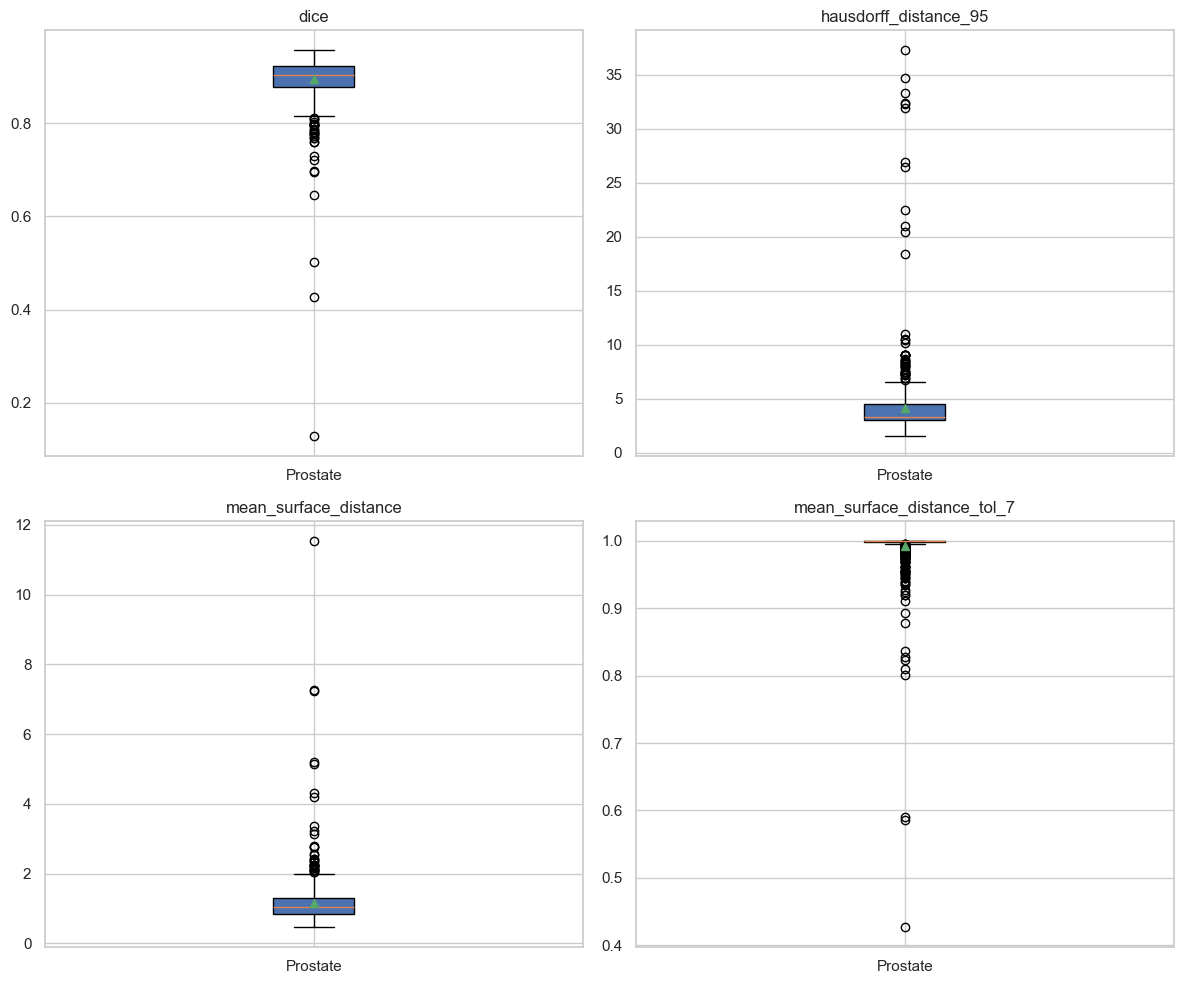

In [27]:
label1_df = metrics_df[metrics_df.label == 1]

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# List of metrics to plot
metrics = [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "mean_surface_distance_tol_7",
]

# Plot each metric
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Extract data for current metric
    label1_data = label1_df[metric]

    # Check if label2_data has values and is not empty
    if not label1_data.empty:
        # Convert data to numeric if necessary
        label1_data = pd.to_numeric(label1_data, errors="coerce")

        # Drop NaN values if any (optional)
        label1_data = label1_data.dropna()

        # Check if after dropping NaN, there's still data
        if not label1_data.empty:
            # Create boxplots side by side
            ax.boxplot([label1_data], patch_artist=True, showmeans=True)
            ax.set_title(f"{metric.split('aimiv2_')[-1]}")
            ax.set_xticklabels(["Prostate"])  # Update x-axis labels to "Lesions"
        else:
            # Handle case where data might be dropped to empty
            print(f"No valid data available for {metric} after cleaning.")
    else:
        # If label2_data is empty, handle accordingly (e.g., print a message)
        print(f"No data available for {metric} in label2 (Lesions).")

# Adjust layout
plt.tight_layout()
plt.show()